In [105]:
import geopandas as gpd
import shapely
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os

In [111]:
file_name = "gr400_vallee_jordanne.gpx"

In [113]:
data_directory = "data"
input_directory = os.path.join(data_directory, "input")
output_directory = os.path.join(data_directory, "output")
input_file_path = os.path.join(input_directory, file_name)
output_file_path = os.path.join(output_directory, file_name)
for directory in [data_directory, input_directory, output_directory]:
    if not os.path.isdir(directory):
        os.mkdir(directory)

In [98]:
gdf = gpd.read_file(input_file_path, layer="tracks")
if gdf.empty:
    gdf = gpd.read_file(input_file_path, layer="routes")

In [99]:
# Explode if necessary
gdf = gdf.explode(ignore_index=True)

In [100]:
# Convert to good crs
gdf = gdf.to_crs(epsg=3857)

In [101]:
# Cut linestrings at max lenght
max_length = gdf.length.sum()/500
gs = shapely.segmentize(gdf["geometry"], max_segment_length=max_length)
gdf = gdf.set_geometry(gs, crs=gdf.crs)

In [102]:
# Cut linestrings into segments
segments = []
for index, row in gdf.iterrows():
    coords = list(row["geometry"].coords)
    for first_point, second_point in zip(coords[:-1], coords[1:]):
        segments.append(shapely.geometry.LineString((first_point, second_point)))
gs = gpd.GeoSeries(segments)
gdf_tmp = gpd.GeoDataFrame(geometry=gs)
gdf = gdf_tmp.set_crs(gdf.crs)

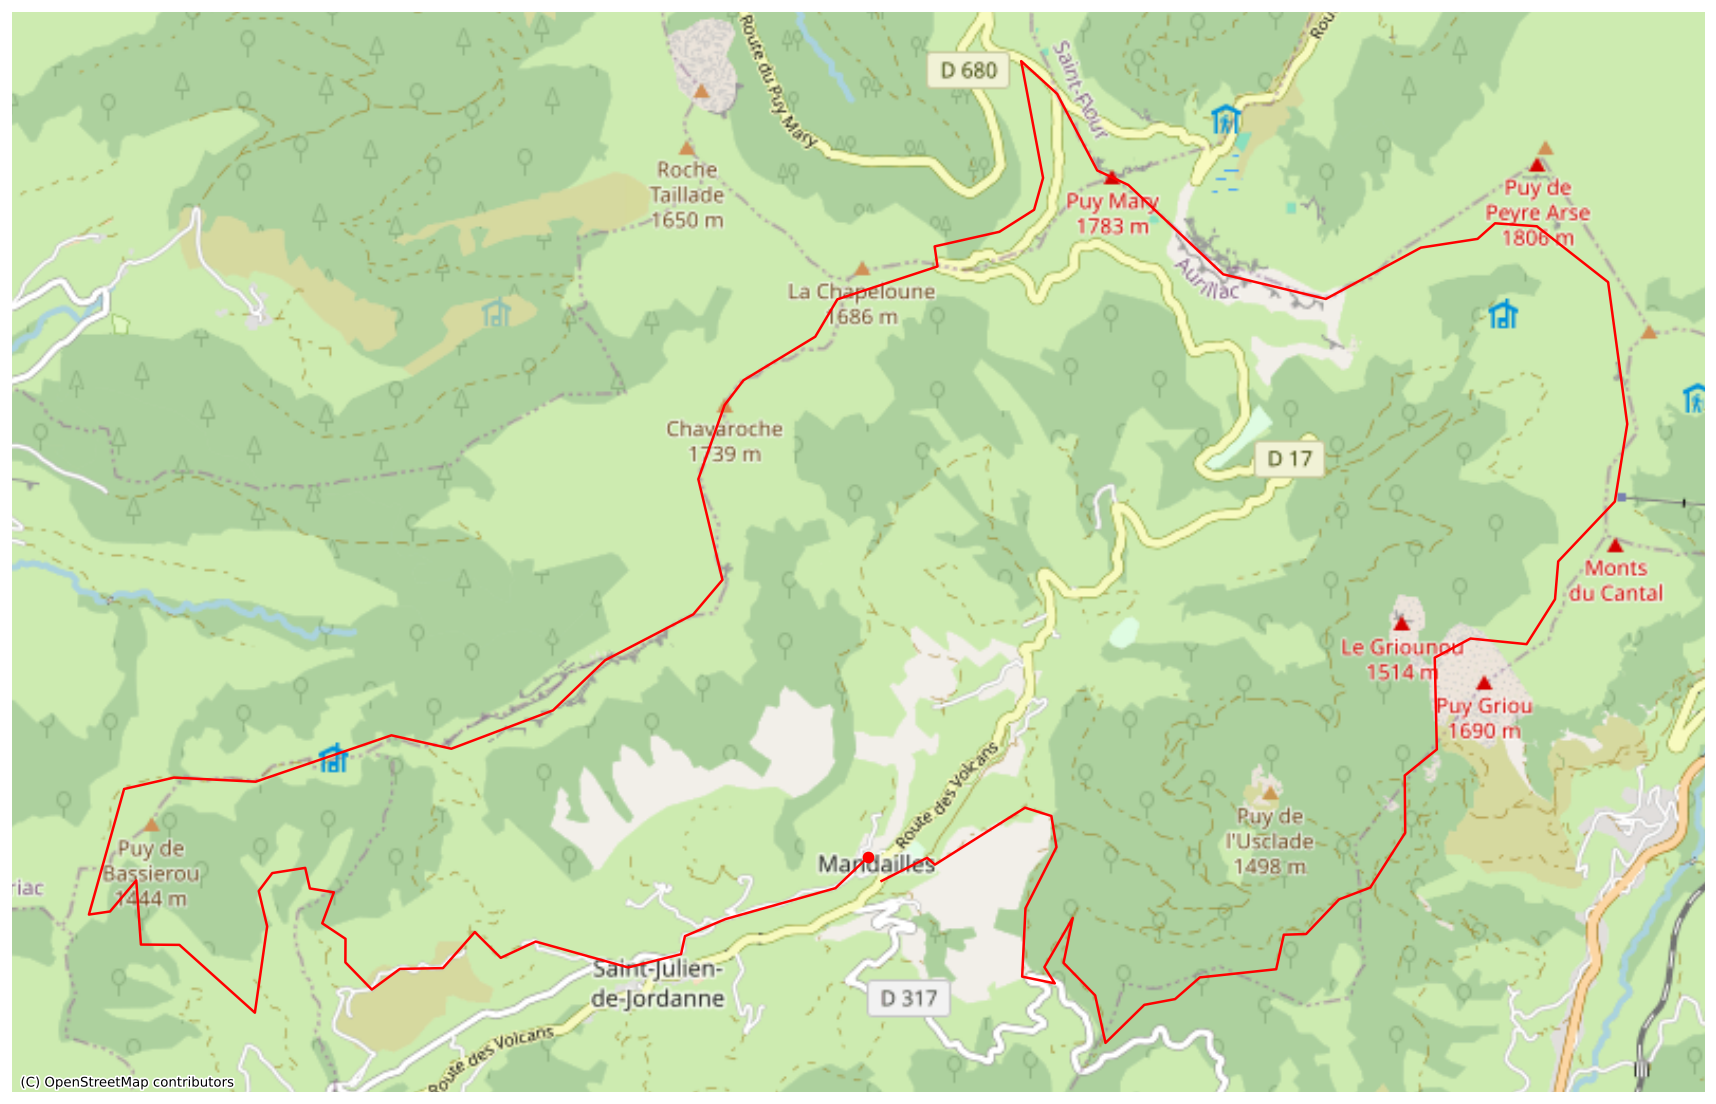

In [103]:
class GeoAnim:
    def __init__(self, ax, gdf):
        # Init variables
        self.gdf = gdf
        self.xs = []
        self.ys = []

        # Init ax
        self.ax = ax
        self.ax.set_axis_off()

        # Init background
        self.gdf.plot(alpha=0, ax=self.ax)
        # cx.providers.GeoportailFrance.Orthoimagery_Orthophotos2020
        cx.add_basemap(self.ax, crs=self.gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

        # Init line and point
        self.scat = self.ax.scatter(x=[], y=[], color="r")
        self.line = self.ax.plot(self.xs, self.ys, color="r")[0]

    def __call__(self, i):
        coords = self.gdf.loc[i, "geometry"].coords
        new_x = [coords[0][0], coords[1][0]]
        new_y = [coords[0][1], coords[1][1]]
        self.xs.append(new_x)
        self.ys.append(new_y)
        self.line.set_xdata(self.xs)
        self.line.set_ydata(self.ys)
        self.scat.set_offsets(coords[1])
        return (self.line, self.scat)

fig, ax = plt.subplots(figsize=(16, 9), dpi=1920/16)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ga = GeoAnim(ax, gdf)

ani = animation.FuncAnimation(fig=fig, func=ga, frames=gdf.index, interval=20, blit=True)
# HTML(ani.to_html5_video())
ani.save(filename=output_file_path, writer="ffmpeg")